In [1]:
!pip install pyspark

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy import stats
import numpy as np
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from IPython.display import IFrame


In [3]:
plt.style.use('ggplot')
sns.set_style("whitegrid")

# Initialize a Spark session
spark = SparkSession.builder.appName("GlobalAirQualityAnalysis").getOrCreate()

In [4]:
# Load the dataset
dataset_path = "C:/Users/Asus/Downloads/globalairpollutiondataset.csv"
df = spark.read.csv(dataset_path, header=True, inferSchema=True)

In [5]:
org_df = df

In [6]:
# Cleaning the data by dropping rows with missing values
df_cleaned = df.dropna()





In [7]:
df.show()

+--------------------+----------------+---------+--------------------+------------+---------------+---------------+--------------------+-------------+----------------+--------------+--------------------+
|             Country|            City|AQI_Value|        AQI_Category|CO_AQI_Value|CO_AQI_Category|Ozone_AQI_Value|  Ozone_AQI_Category|NO2_AQI_Value|NO2_AQI_Category|PM25_AQI_Value|   PM25_AQI_Category|
+--------------------+----------------+---------+--------------------+------------+---------------+---------------+--------------------+-------------+----------------+--------------+--------------------+
|  Russian Federation|      Praskoveya|       51|            Moderate|           1|           Good|             36|                Good|            0|            Good|            51|            Moderate|
|              Brazil|Presidente Dutra|       41|                Good|           1|           Good|              5|                Good|            1|            Good|            41|  

In [8]:
df.printSchema()

root
 |-- Country: string (nullable = true)
 |-- City: string (nullable = true)
 |-- AQI_Value: integer (nullable = true)
 |-- AQI_Category: string (nullable = true)
 |-- CO_AQI_Value: integer (nullable = true)
 |-- CO_AQI_Category: string (nullable = true)
 |-- Ozone_AQI_Value: integer (nullable = true)
 |-- Ozone_AQI_Category: string (nullable = true)
 |-- NO2_AQI_Value: integer (nullable = true)
 |-- NO2_AQI_Category: string (nullable = true)
 |-- PM25_AQI_Value: integer (nullable = true)
 |-- PM25_AQI_Category: string (nullable = true)



In [9]:
# Cleaning the data by dropping rows with missing values
df_dup = df.groupBy(
    "Country", "City", "AQI_Value", "AQI_Category",
    "CO_AQI_Value", "CO_AQI_Category", "Ozone_AQI_Value", "Ozone_AQI_Category",
    "NO2_AQI_Value", "NO2_AQI_Category","PM25_AQI_Value","PM25_AQI_Category"
).count().filter("count > 1")

df_dup.drop('count').show()



+-------+----+---------+------------+------------+---------------+---------------+------------------+-------------+----------------+--------------+-----------------+
|Country|City|AQI_Value|AQI_Category|CO_AQI_Value|CO_AQI_Category|Ozone_AQI_Value|Ozone_AQI_Category|NO2_AQI_Value|NO2_AQI_Category|PM25_AQI_Value|PM25_AQI_Category|
+-------+----+---------+------------+------------+---------------+---------------+------------------+-------------+----------------+--------------+-----------------+
+-------+----+---------+------------+------------+---------------+---------------+------------------+-------------+----------------+--------------+-----------------+



In [10]:
df.show()


+--------------------+----------------+---------+--------------------+------------+---------------+---------------+--------------------+-------------+----------------+--------------+--------------------+
|             Country|            City|AQI_Value|        AQI_Category|CO_AQI_Value|CO_AQI_Category|Ozone_AQI_Value|  Ozone_AQI_Category|NO2_AQI_Value|NO2_AQI_Category|PM25_AQI_Value|   PM25_AQI_Category|
+--------------------+----------------+---------+--------------------+------------+---------------+---------------+--------------------+-------------+----------------+--------------+--------------------+
|  Russian Federation|      Praskoveya|       51|            Moderate|           1|           Good|             36|                Good|            0|            Good|            51|            Moderate|
|              Brazil|Presidente Dutra|       41|                Good|           1|           Good|              5|                Good|            1|            Good|            41|  

In [11]:
print('Missing: {}'.format(df.filter(df['Country'] == 'NONE').count()))
print('Missing: {}'.format(df.filter(df['City'] == 'NONE').count()))
print('Missing: {}'.format(df.filter(df['PM25_AQI_Value'] == 'NONE').count()))
print('Missing: {}'.format(df.filter(df['PM25_AQI_Category'] == 'NONE').count()))
print('Missing: {}'.format(df.filter(df['Ozone_AQI_Category'] == 'NONE').count()))
print('Missing: {}'.format(df.filter(df['AQI_Value'] == 'NONE').count()))






Missing: 0
Missing: 0
Missing: 0
Missing: 0
Missing: 0
Missing: 0


In [12]:
df.describe(['AQI_Value', 'Ozone_AQI_Value', 'NO2_AQI_Value','PM25_AQI_Value']).show()




+-------+-----------------+------------------+------------------+-----------------+
|summary|        AQI_Value|   Ozone_AQI_Value|     NO2_AQI_Value|   PM25_AQI_Value|
+-------+-----------------+------------------+------------------+-----------------+
|  count|            23463|             23463|             23463|            23463|
|   mean|72.01086817542513| 35.19370924434216|3.0633337595362913|68.51975450709628|
| stddev|56.05522025223742|28.098723409527004| 5.254108426652412|54.79644316021085|
|    min|                6|                 0|                 0|                0|
|    max|              500|               235|                91|              500|
+-------+-----------------+------------------+------------------+-----------------+



In [13]:
#Creating Table Based on Spark Data Frame to perform SQL Queries
df.createOrReplaceTempView("countrydata")



In [14]:
#Highest Polluted Country
spark.sql('''
    SELECT *
    FROM countrydata
    WHERE AQI_Value == (SELECT MAX(AQI_Value) FROM countrydata)''').show()

+--------+------------+---------+------------+------------+---------------+---------------+------------------+-------------+----------------+--------------+-----------------+
| Country|        City|AQI_Value|AQI_Category|CO_AQI_Value|CO_AQI_Category|Ozone_AQI_Value|Ozone_AQI_Category|NO2_AQI_Value|NO2_AQI_Category|PM25_AQI_Value|PM25_AQI_Category|
+--------+------------+---------+------------+------------+---------------+---------------+------------------+-------------+----------------+--------------+-----------------+
|Pakistan|Bahawalnagar|      500|   Hazardous|           1|           Good|             38|              Good|            1|            Good|           466|        Hazardous|
|   India|       Rania|      500|   Hazardous|           1|           Good|             40|              Good|            0|            Good|           464|        Hazardous|
|   India|      Gohana|      500|   Hazardous|           1|           Good|             47|              Good|            1| 

In [15]:
#Highest Polluted Country
spark.sql('''
    SELECT Country, AQI_Value
    FROM countrydata
    WHERE AQI_Value == (SELECT MAX(AQI_Value) FROM countrydata)''').show()

+--------+---------+
| Country|AQI_Value|
+--------+---------+
|Pakistan|      500|
|   India|      500|
|   India|      500|
|   India|      500|
|Pakistan|      500|
|   India|      500|
|   India|      500|
|   India|      500|
|   India|      500|
|   India|      500|
|Pakistan|      500|
|Pakistan|      500|
|   India|      500|
|   India|      500|
|   India|      500|
|   India|      500|
|   India|      500|
|   India|      500|
|   India|      500|
|   India|      500|
+--------+---------+
only showing top 20 rows



In [16]:
#Highest Polluted City
df.createOrReplaceTempView("citydata")
spark.sql('''
    SELECT City, AQI_Value
    FROM citydata
    WHERE AQI_Value == (SELECT MAX(AQI_Value) FROM citydata)''').show()

+------------+---------+
|        City|AQI_Value|
+------------+---------+
|Bahawalnagar|      500|
|       Rania|      500|
|      Gohana|      500|
|     Gunnaur|      500|
|   Harunabad|      500|
|      Khetri|      500|
| Jahangirpur|      500|
|     Kakrala|      500|
|     Kandhla|      500|
|Mahendragarh|      500|
|     Lodhran|      500|
|      Mailsi|      500|
|    Gajraula|      500|
|      Nagaur|      500|
|    Dataganj|      500|
|    Pilkhuwa|      500|
|      Siwani|      500|
|   Shamsabad|      500|
|     Phalodi|      500|
|      Kanina|      500|
+------------+---------+
only showing top 20 rows



In [17]:
df = spark.sql('''
          SELECT Country,City, AQI_Value, RANK() OVER(PARTITION BY City 
          ORDER BY AQI_Value DESC) Rank
          FROM citydata
          ORDER BY AQI_Value DESC
          LIMIT 20''')
df.show(20)

+--------------------+------------+---------+----+
|             Country|        City|AQI_Value|Rank|
+--------------------+------------+---------+----+
|               India|  Faridnagar|      500|   1|
|               India|   Faridabad|      500|   1|
|               India|    Bisalpur|      500|   1|
|               India|Chhachhrauli|      500|   1|
|               India|    Barkhera|      500|   1|
|               India|       Bagar|      500|   1|
|United States of ...|     Durango|      500|   1|
|            Pakistan|Bahawalnagar|      500|   1|
|               India|     Balotra|      500|   1|
|               India|     Didwana|      500|   1|
|               India|      Bahjoi|      500|   1|
|               India|       Bawal|      500|   1|
|               India|       Churu|      500|   1|
|               India|      Bhadra|      500|   1|
|               India|     Dabwali|      500|   1|
|               India|      Bilari|      500|   1|
|               India|    Datag

In [18]:
#Lowesst Air Pollution Country and City
df = spark.sql('''
SELECT Country, City, AQI_Value, RANK() OVER(PARTITION BY City 
ORDER BY AQI_Value ASC) AS Rank
FROM citydata
ORDER BY AQI_Value ASC
LIMIT 20
''')
df.show(20)

+--------------------+------------------+---------+----+
|             Country|              City|AQI_Value|Rank|
+--------------------+------------------+---------+----+
|Bolivia (Plurinat...|          El Torno|        6|   1|
|             Ecuador|             Macas|        7|   1|
|             Ecuador|           Azogues|        8|   1|
|    Papua New Guinea|              Tari|        8|   1|
|                Peru|            Huaraz|        9|   1|
|            Colombia|             Guapi|       10|   1|
|                Peru|             Junin|       10|   1|
|            Colombia|       Puerto Asis|       10|   1|
|                Peru|      Huancavelica|       10|   1|
|           Indonesia|         Manokwari|       10|   1|
|             Ecuador|        Nueva Loja|       10|   1|
|              Brazil|         Andradina|       11|   1|
|           Argentina|Comodoro Rivadavia|       11|   1|
|                Peru|          La Oroya|       11|   1|
|    Papua New Guinea|         

In [19]:
#TOP 10 Polluted Country
df= spark.sql('''
SELECT Country, AVG(AQI_Value) as average_aqi
FROM countrydata
Group by Country
Order by average_aqi DESC
''')
df.show(10)

+--------------------+------------------+
|             Country|       average_aqi|
+--------------------+------------------+
|   Republic of Korea|             421.0|
|             Bahrain|             188.0|
|          Mauritania|             179.0|
|            Pakistan|178.78827361563518|
|United Arab Emirates|163.66666666666666|
|               Aruba|             163.0|
|              Kuwait|             162.0|
|               Qatar|             157.5|
|               India|152.96422829581994|
|             Senegal|152.42424242424244|
+--------------------+------------------+
only showing top 10 rows



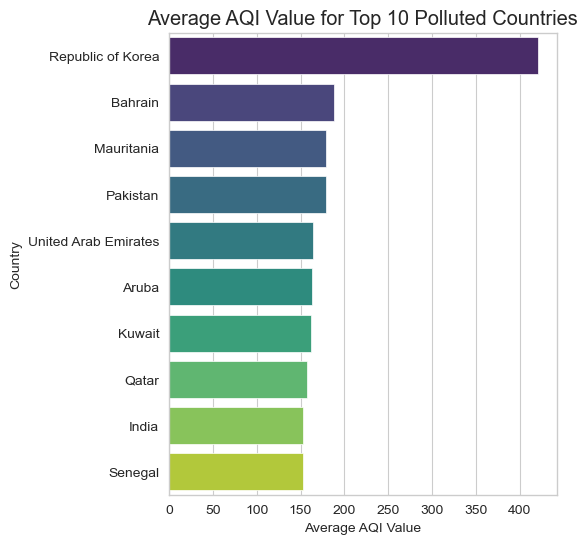

In [20]:
#TOP 10 Polluted Countries by Average AQI Value
df_average_aqi = df.toPandas()
df_top10 = df_average_aqi.head(10)
plt.figure(figsize=(5, 6))
sns.barplot(y='Country', x='average_aqi', data=df_top10, palette='viridis')
plt.title('Average AQI Value for Top 10 Polluted Countries')
plt.xlabel('Average AQI Value')
plt.ylabel('Country')
plt.show(10)


In [21]:
# Calculate average AQI per country
df_AQICategory= spark.sql('''
    SELECT c.Country, c.AQI_Category,AVG(c.AQI_Value) AS average_aqi
    FROM countrydata c
    GROUP BY c.Country, c.AQI_Category
    ORDER BY average_aqi DESC
''')
df.show()




+--------------------+------------------+
|             Country|       average_aqi|
+--------------------+------------------+
|   Republic of Korea|             421.0|
|             Bahrain|             188.0|
|          Mauritania|             179.0|
|            Pakistan|178.78827361563518|
|United Arab Emirates|163.66666666666666|
|               Aruba|             163.0|
|              Kuwait|             162.0|
|               Qatar|             157.5|
|               India|152.96422829581994|
|             Senegal|152.42424242424244|
|        Saudi Arabia|149.28571428571428|
|              Gambia|             147.0|
|               Yemen|144.57142857142858|
|       Guinea-Bissau|            138.75|
|                Oman|             137.5|
|               China|126.95345911949686|
| Kingdom of Eswatini|119.33333333333333|
|          Uzbekistan|119.08620689655173|
|               Nepal|116.36363636363636|
|          Tajikistan|115.20689655172414|
+--------------------+------------

In [22]:
df_AQICategory.show()

+--------------------+--------------+------------------+
|             Country|  AQI_Category|       average_aqi|
+--------------------+--------------+------------------+
|United States of ...|     Hazardous|             500.0|
|  Russian Federation|     Hazardous|             500.0|
|               India|     Hazardous|450.62025316455697|
|   Republic of Korea|     Hazardous|             421.0|
|            Pakistan|     Hazardous|419.46153846153845|
|Democratic Republ...|     Hazardous|             415.0|
|        South Africa|     Hazardous|             403.0|
|               Chile|     Hazardous|             358.0|
|              Mexico|     Hazardous| 339.6666666666667|
|               China|     Hazardous| 332.3333333333333|
|          Uzbekistan|     Hazardous|             300.0|
|              Angola|Very Unhealthy|             285.0|
|           Australia|Very Unhealthy|             264.0|
|Democratic Republ...|Very Unhealthy|             249.5|
|              Brazil|Very Unhe

In [23]:
categorycount=df_AQICategory.groupBy('AQI_Category').count().show() 

+--------------------+-----+
|        AQI_Category|count|
+--------------------+-----+
|           Unhealthy|   69|
|                Good|  140|
|Unhealthy for Sen...|   96|
|           Hazardous|   11|
|            Moderate|  154|
|      Very Unhealthy|   21|
+--------------------+-----+



In [24]:
AQIcategory_list=['Hazardous','Very_Unhealthy','Unhealthy','Unhealthy_for_SensitiveGroups','Moderate','Good']

In [25]:
# Define and execute a Spark SQL query to create df_AQIcategory

df_AQIcategory = spark.sql('''
    SELECT Country, AQI_Category, AVG(AQI_Value) AS AVG_AQI_Value
    FROM countrydata GROUP BY Country, AQI_Category
    ORDER BY AVG_AQI_Value
''')

df_AQIcategory.show()

# Convert the Spark DataFrame to a Pandas DataFrame
df_AQIcategory_pandas = df_AQIcategory.toPandas()

# Now you can use the df_AQIcategory_pandas DataFrame as needed


+--------------------+------------+------------------+
|             Country|AQI_Category|     AVG_AQI_Value|
+--------------------+------------+------------------+
|               Palau|        Good|              16.0|
|     Solomon Islands|        Good|              18.0|
|            Maldives|        Good|              19.0|
|    Papua New Guinea|        Good|19.214285714285715|
|         New Zealand|        Good|21.352941176470587|
|Bolivia (Plurinat...|        Good|21.419354838709676|
|              Belize|        Good|              22.0|
|           Argentina|        Good|22.262295081967213|
|             Iceland|        Good|              23.0|
|             Uruguay|        Good|             25.64|
|            Paraguay|        Good| 25.68421052631579|
|          Luxembourg|        Good|              26.0|
|          Seychelles|        Good|              26.0|
|              Bhutan|        Good|              26.0|
|          Madagascar|        Good|26.214285714285715|
|         

In [26]:
df_subset = df_AQIcategory_pandas[df_AQIcategory_pandas['AQI_Category'].isin(AQIcategory_list)]

In [27]:
df_subset

,Country,AQI_Category,AVG_AQI_Value
0,Palau,Good,16.000000
1,Solomon Islands,Good,18.000000
2,Maldives,Good,19.000000
3,Papua New Guinea,Good,19.214286
4,New Zealand,Good,21.352941
...,...,...,...
486,Pakistan,Hazardous,419.461538
487,Republic of Korea,Hazardous,421.000000
488,India,Hazardous,450.620253
489,United States of America,Hazardous,500.000000


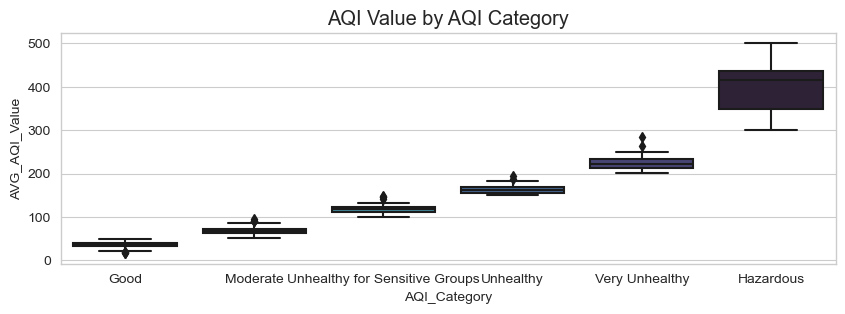

In [28]:
# for AQIcategory in AQIcategory_list:
df_subset = df_AQIcategory_pandas[df_AQIcategory_pandas['AQI_Category'].isin(AQIcategory_list)]
plt.figure(figsize=(10, 3))
sns.boxplot(x='AQI_Category', y='AVG_AQI_Value', data=df_AQIcategory_pandas, palette='mako_r')
plt.title('AQI Value by AQI Category')
plt.show()



In [29]:
df = org_df

In [30]:
spark.sql("""
    SELECT Ozone_AQI_Value FROM countrydata
""").show()

+---------------+
|Ozone_AQI_Value|
+---------------+
|             36|
|              5|
|             39|
|             34|
|             22|
|             14|
|             35|
|             29|
|             41|
|             89|
|             68|
|             24|
|            139|
|             50|
|             46|
|             30|
|            100|
|             47|
|              4|
|             71|
+---------------+
only showing top 20 rows



In [31]:
df_encoded = spark.sql('''
    SELECT Country, AQI_Category, AVG(AQI_Value) AS AVG_AQI_Value, AVG(Ozone_AQI_Value) AS AVG_Ozone_AQI_Value
    FROM countrydata GROUP BY Country, AQI_Category
    ORDER BY AVG_AQI_Value
''')

In [32]:
df_encoded.show()

+--------------------+------------+------------------+-------------------+
|             Country|AQI_Category|     AVG_AQI_Value|AVG_Ozone_AQI_Value|
+--------------------+------------+------------------+-------------------+
|               Palau|        Good|              16.0|               16.0|
|     Solomon Islands|        Good|              18.0|               18.0|
|            Maldives|        Good|              19.0|               19.0|
|    Papua New Guinea|        Good|19.214285714285715| 15.285714285714286|
|         New Zealand|        Good|21.352941176470587| 18.647058823529413|
|Bolivia (Plurinat...|        Good|21.419354838709676|  8.129032258064516|
|              Belize|        Good|              22.0|               22.0|
|           Argentina|        Good|22.262295081967213| 15.819672131147541|
|             Iceland|        Good|              23.0|               23.0|
|             Uruguay|        Good|             25.64|              19.28|
|            Paraguay|   

In [33]:
df_AQIcategory.show()

+--------------------+------------+------------------+
|             Country|AQI_Category|     AVG_AQI_Value|
+--------------------+------------+------------------+
|               Palau|        Good|              16.0|
|     Solomon Islands|        Good|              18.0|
|            Maldives|        Good|              19.0|
|    Papua New Guinea|        Good|19.214285714285715|
|         New Zealand|        Good|21.352941176470587|
|Bolivia (Plurinat...|        Good|21.419354838709676|
|              Belize|        Good|              22.0|
|           Argentina|        Good|22.262295081967213|
|             Iceland|        Good|              23.0|
|             Uruguay|        Good|             25.64|
|            Paraguay|        Good| 25.68421052631579|
|          Luxembourg|        Good|              26.0|
|          Seychelles|        Good|              26.0|
|              Bhutan|        Good|              26.0|
|          Madagascar|        Good|26.214285714285715|
|         

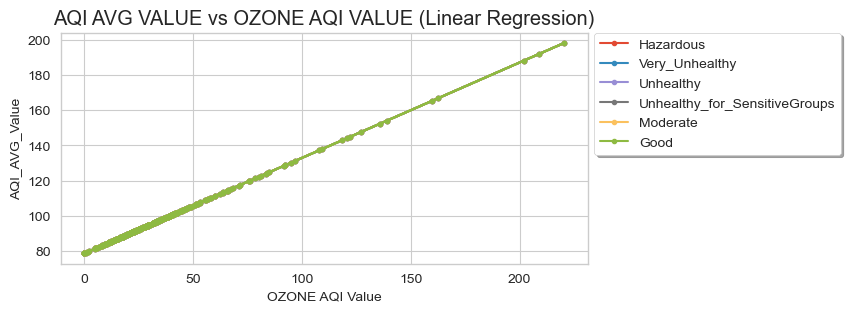

In [34]:
from sklearn.linear_model import LinearRegression

from pyspark.sql.functions import col

X = df_encoded.select('AVG_Ozone_AQI_Value').toPandas()
y = df_encoded.select('AVG_AQI_Value').toPandas()

# Create a LinearRegression model
model = LinearRegression()

slope_list = []
intercept_list = []

plt.figure(figsize=(6.8, 3))
for i in range(6):
    # Fit the model to the data
    model.fit(X, y)
    
    slope = model.coef_[0]
    intercept = model.intercept_
    
    slope_list.append(slope)
    intercept_list.append(intercept)
    
    plt.plot(X, slope*X + intercept, label=AQIcategory_list[i], marker='.')
    plt.legend(bbox_to_anchor=(1, 1.03), ncol=1, fancybox=True, shadow=True)
    
plt.ylabel('AQI_AVG_Value')
plt.xlabel('OZONE AQI Value')
plt.title('AQI AVG VALUE vs OZONE AQI VALUE (Linear Regression)')
plt.show()


In [35]:
#Preprocess the data for ML training
df.show(1)

+------------------+----------+---------+------------+------------+---------------+---------------+------------------+-------------+----------------+--------------+-----------------+
|           Country|      City|AQI_Value|AQI_Category|CO_AQI_Value|CO_AQI_Category|Ozone_AQI_Value|Ozone_AQI_Category|NO2_AQI_Value|NO2_AQI_Category|PM25_AQI_Value|PM25_AQI_Category|
+------------------+----------+---------+------------+------------+---------------+---------------+------------------+-------------+----------------+--------------+-----------------+
|Russian Federation|Praskoveya|       51|    Moderate|           1|           Good|             36|              Good|            0|            Good|            51|         Moderate|
+------------------+----------+---------+------------+------------+---------------+---------------+------------------+-------------+----------------+--------------+-----------------+
only showing top 1 row



In [36]:
df_encoded.printSchema()

root
 |-- Country: string (nullable = true)
 |-- AQI_Category: string (nullable = true)
 |-- AVG_AQI_Value: double (nullable = true)
 |-- AVG_Ozone_AQI_Value: double (nullable = true)



In [37]:
#Create a copy of the data frame called 'df_encoded'
df_encoded = df.alias('df_encoded')
id(df_encoded) == id(df)

False

In [38]:
cols = df_encoded.columns

In [39]:
cols

['Country',
 'City',
 'AQI_Value',
 'AQI_Category',
 'CO_AQI_Value',
 'CO_AQI_Category',
 'Ozone_AQI_Value',
 'Ozone_AQI_Category',
 'NO2_AQI_Value',
 'NO2_AQI_Category',
 'PM25_AQI_Value',
 'PM25_AQI_Category']

In [40]:
df_AQICategory.show()

+--------------------+--------------+------------------+
|             Country|  AQI_Category|       average_aqi|
+--------------------+--------------+------------------+
|United States of ...|     Hazardous|             500.0|
|  Russian Federation|     Hazardous|             500.0|
|               India|     Hazardous|450.62025316455697|
|   Republic of Korea|     Hazardous|             421.0|
|            Pakistan|     Hazardous|419.46153846153845|
|Democratic Republ...|     Hazardous|             415.0|
|        South Africa|     Hazardous|             403.0|
|               Chile|     Hazardous|             358.0|
|              Mexico|     Hazardous| 339.6666666666667|
|               China|     Hazardous| 332.3333333333333|
|          Uzbekistan|     Hazardous|             300.0|
|              Angola|Very Unhealthy|             285.0|
|           Australia|Very Unhealthy|             264.0|
|Democratic Republ...|Very Unhealthy|             249.5|
|              Brazil|Very Unhe

In [41]:
df_average_aqi = df_AQICategory.select('average_aqi').toPandas()

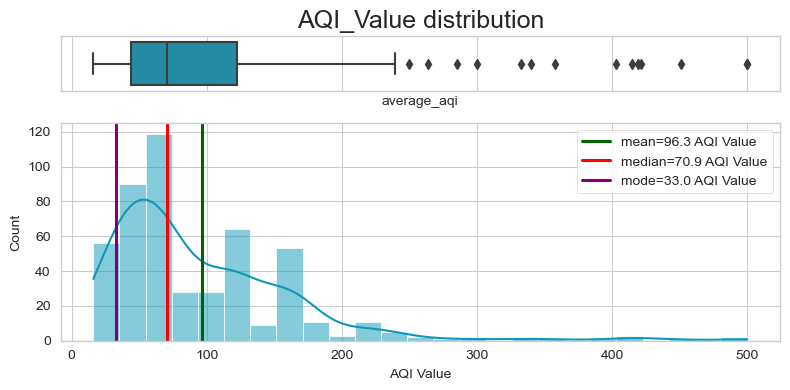

In [42]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 4), gridspec_kw={"height_ratios": (.2, .8)})
ax[0].set_title('AQI_Value distribution', fontsize=18)

# Create a boxplot to visualize the spread of AQI values
sns.boxplot(x=df_average_aqi['average_aqi'], ax=ax[0], color='#0d98ba')
ax[0].set(yticks=[])

# Create a histogram to visualize the distribution of AQI values
sns.histplot(x='average_aqi', data=df_average_aqi, ax=ax[1], color='#0d98ba', kde=True)  # Use kde=True to add KDE curve

# Add vertical lines to indicate mean, median, and mode
plt.axvline(df_average_aqi['average_aqi'].mean(), color='darkgreen', linewidth=2.2, label='mean=' + str(np.round(df_average_aqi['average_aqi'].mean(), 1)) + ' AQI Value')
plt.axvline(df_average_aqi['average_aqi'].median(), color='red', linewidth=2.2, label='median=' + str(np.round(df_average_aqi['average_aqi'].median(), 1)) + ' AQI Value')
plt.axvline(df_average_aqi['average_aqi'].mode()[0], color='purple', linewidth=2.2, label='mode=' + str(df_average_aqi['average_aqi'].mode()[0]) + ' AQI Value')

ax[1].set_xlabel('AQI Value')
plt.legend()
plt.tight_layout()
plt.show()


In [43]:
df_new = spark.sql('''
    SELECT Country, AQI_Category, AVG(AQI_Value) AS AVG_AQI_Value, AVG(Ozone_AQI_Value) AS AVG_Ozone_AQI_Value
    FROM countrydata GROUP BY Country, AQI_Category
    ORDER BY AVG_AQI_Value
''')

In [44]:
df_new.show()

+--------------------+------------+------------------+-------------------+
|             Country|AQI_Category|     AVG_AQI_Value|AVG_Ozone_AQI_Value|
+--------------------+------------+------------------+-------------------+
|               Palau|        Good|              16.0|               16.0|
|     Solomon Islands|        Good|              18.0|               18.0|
|            Maldives|        Good|              19.0|               19.0|
|    Papua New Guinea|        Good|19.214285714285715| 15.285714285714286|
|         New Zealand|        Good|21.352941176470587| 18.647058823529413|
|Bolivia (Plurinat...|        Good|21.419354838709676|  8.129032258064516|
|              Belize|        Good|              22.0|               22.0|
|           Argentina|        Good|22.262295081967213| 15.819672131147541|
|             Iceland|        Good|              23.0|               23.0|
|             Uruguay|        Good|             25.64|              19.28|
|            Paraguay|   

In [45]:
#Label Encoding
categoricalColumns = ["Country", "AQI_Category", "AVG_AQI_Value", 
                      "AVG_Ozone_AQI_Value"]
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, 
    outputCol = categoricalCol + 'Index')
    stages += [stringIndexer]
numericCols =  ["AVG_Ozone_AQI_Value", "AVG_AQI_Value"]
assemblerInputs = [c + "Index" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [46]:
stages = []
stringIndexer = StringIndexer(inputCol = "AQI_Category", 
                              outputCol = "categoryIndex")
stages += [stringIndexer]

In [47]:
#One HOT Encoding
categoricalColumns = ["Country", "AQI_Category", "AVG_AQI_Value", 
                      "AVG_Ozone_AQI_Value"]
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, 
    outputCol = categoricalCol + 'Index', handleInvalid="skip")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], 
    outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
numericCols =  ["AVG_AQI_Value", "AVG_Ozone_AQI_Value"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + 
numericCols + ["categoryIndex"]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [48]:
_pipeline = Pipeline(stages = stages)
pipelineModel = _pipeline.fit(df_new)
df_encoded_M = pipelineModel.transform(df_new)
selectedCols = ['features'] + df_new.columns

In [49]:
df_encoded_M = df_encoded_M.select(selectedCols)

In [50]:
df_encoded_M.show()

+--------------------+--------------------+------------+------------------+-------------------+
|            features|             Country|AQI_Category|     AVG_AQI_Value|AVG_Ozone_AQI_Value|
+--------------------+--------------------+------------+------------------+-------------------+
|(998,[163,175,313...|               Palau|        Good|              16.0|               16.0|
|(998,[171,175,339...|     Solomon Islands|        Good|              18.0|               18.0|
|(998,[160,175,342...|            Maldives|        Good|              19.0|               19.0|
|(998,[136,175,343...|    Papua New Guinea|        Good|19.214285714285715| 15.285714285714286|
|(998,[134,175,346...|         New Zealand|        Good|21.352941176470587| 18.647058823529413|
|(998,[96,175,347,...|Bolivia (Plurinat...|        Good|21.419354838709676|  8.129032258064516|
|(998,[95,175,352,...|              Belize|        Good|              22.0|               22.0|
|(998,[47,175,353,...|           Argenti

In [51]:
df_encoded_M.show()

+--------------------+--------------------+------------+------------------+-------------------+
|            features|             Country|AQI_Category|     AVG_AQI_Value|AVG_Ozone_AQI_Value|
+--------------------+--------------------+------------+------------------+-------------------+
|(998,[163,175,313...|               Palau|        Good|              16.0|               16.0|
|(998,[171,175,339...|     Solomon Islands|        Good|              18.0|               18.0|
|(998,[160,175,342...|            Maldives|        Good|              19.0|               19.0|
|(998,[136,175,343...|    Papua New Guinea|        Good|19.214285714285715| 15.285714285714286|
|(998,[134,175,346...|         New Zealand|        Good|21.352941176470587| 18.647058823529413|
|(998,[96,175,347,...|Bolivia (Plurinat...|        Good|21.419354838709676|  8.129032258064516|
|(998,[95,175,352,...|              Belize|        Good|              22.0|               22.0|
|(998,[47,175,353,...|           Argenti

In [52]:
train, test = df_encoded_M.randomSplit([0.80, 0.20], seed = 42)

In [55]:
train.count()

414

In [59]:
print("There are %d training examples and %d test examples." % 
      (train.count(), test.count()))

There are 414 training examples and 72 test examples.


In [64]:
#Gradient Boosted Tree Regression Model
gbt =  GBTRegressor(featuresCol="features", labelCol="AVG_AQI_Value", 
                    maxBins=20, maxDepth=12)

In [65]:
gbt_model = gbt.fit(train)

In [66]:
#Prediction
predictions = gbt_model.transform(test)

In [69]:
#Prediction Results of Regression Model Root Mean Square Error
evaluator = RegressionEvaluator(labelCol="AVG_AQI_Value", 
            predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
rmse

15.963838519671397

In [70]:
evaluator = RegressionEvaluator(labelCol="AVG_AQI_Value", 
            predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
r2

0.966558757279589

In [71]:
rf_results = predictions.toPandas()

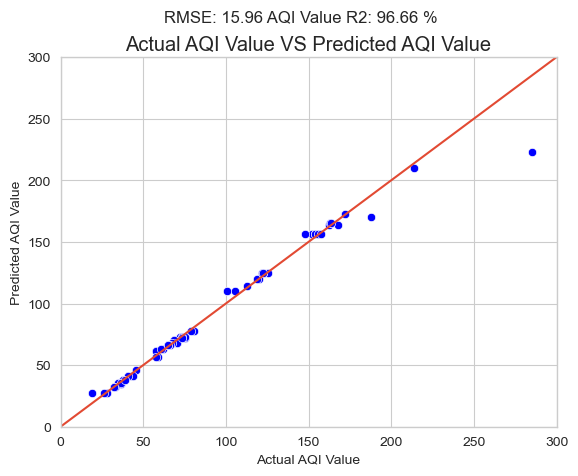

In [75]:
sns.scatterplot(x='AVG_AQI_Value', y='prediction', data=rf_results, 
                color='blue')
plt.plot([0, 300], [0, 300])
plt.axis([0, 300, 0, 300])
plt.xlabel('Actual AQI Value')
plt.ylabel('Predicted AQI Value')
plt.suptitle("RMSE: {:.2f} AQI Value R2: {:.2f} %".format(rmse, r2*100))
plt.title('Actual AQI Value VS Predicted AQI Value')
plt.show()

In [76]:
print("RMSE: {:.2f} AQI Value \nR2: {:.2f} %".format(rmse, r2*100))

RMSE: 15.96 AQI Value 
R2: 96.66 %


In [ ]:
#spark.stop()

In [5]:
#Tableau Visualization Dashboard
IFrame('https://public.tableau.com/views/RajLama_BigData_Assignment/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link', width=1080, height=925)
